# Méthode de Pénalisation

Dans cette partie on se propose de résoudre le problème suivant : 

$$\left\{
    \begin{array}{ll}
        \Delta \Phi &= F &\text{sur } \Omega_i \\
        \Phi_{\partial \Omega_i} & = 1 \\
        \Phi_{\partial \Omega} & = 0 \\
    \end{array}
   \right.
$$

Nous avons vu en cours que ce problème est équivalent au suivant : 

$$\left\{
    \begin{array}{ll}
        \Delta \Phi_{\epsilon} &= \chi_{\Omega \backslash \Omega_i} (\dfrac{\Phi_{\epsilon}-K}{\epsilon}) + F &\text{sur  } \Omega \\
        \Phi_{\partial \Omega} & = 0 \\
    \end{array}
   \right.
$$

Avec 
$$\chi_{\Omega \backslash \Omega_i} = \left\{
    \begin{array}{ll}
      0 &\text{si   } x \in \Omega_i\\
      1 &\text{sinon} \\
    \end{array}
   \right.
$$

En effet, si l'on multiplie par $\epsilon$ de chaque côté de l'équation on obtient :

$$ \epsilon \Delta \Phi_{\epsilon} = \chi_{\Omega \backslash \Omega_i} (\Phi_{\epsilon}-K) + \epsilon F $$

On observe alors 2 cas de figures :

- $ x \in \Omega \backslash \Omega_i \Longrightarrow \Delta \Phi_{\epsilon} = F$
- $ x \in \Omega_i $ alors on fait tendre $\epsilon$ vers 0 et on observe $(\Phi_{\epsilon}-K) = 0 \Longrightarrow \Phi_{\epsilon} = K$



In [1]:
import numpy as np                        #Package pour calculs scientifiques
import scipy.sparse as sparse             #Algèbre linéaire creuse
import matplotlib.pyplot as plt           #Permet la création de graphique  
import scipy.sparse.linalg as sci         #Contient plusieurs packages pour le calcul scientifique
from mpl_toolkits.mplot3d import Axes3D   #Utile pou le graphiques 3D
import time                               #Affichage du temps de calcul
from IPython.display import Image         #Affichage d'image dans le Jupyter

In [2]:
def matrix_lap(N):
    """Retourne une matrice qui discrétise le laplacien de u dans le domaine Omega = [xmin,xmax,ymin,ymax], découpé en N intervalles en x et y. La matrice finale est une matrice scipy.sparse CSR matrix. Cette matrice est de taille (N+1)*(N+1)"""

    h = 1./N
    h2 = h*h

    #On note les inconnues de 0 à Nx suivant x et 0 à Ny suivant y. La taille du problème est donc (Nx+1)*(Ny+1).

    #Cela correspond à x_i = i*h et y_j = j*h et la numérotation (i,j) --> k := (N+1)*j+i.

    taille = (1+N)*(1+N)

    diags = np.zeros((5,taille))

    #Diagonale principale
    diags[2,:] = 1.
    diags[2, N+2:taille - (N+2)] = -4./h2 
    diags[2, np.arange(2*N+1, taille, N+1)] = 1.
    diags[2, np.arange(2*N+2, taille, N+1)] = 1.
              
    #Diagonale "-1"
    diags[1,N+1:taille-(N+1)] = 1./h2
    diags[1, np.arange(2*N, taille, N+1)] = 0.
    diags[1, np.arange(2*N+1, taille, N+1)] = 0.
    
    #Diagonale "+1"
    diags[3, N+3:taille-(N+1)] = 1./h2
    diags[3, np.arange(2*N+2, taille, N+1)] = 0.
    diags[3, np.arange(2*N+3, taille, N+1)] = 0.

    #Diagonale "-(N+1)"
    diags[0, 1 : taille - (2*N+3)] = 1./h2
    diags[0, np.arange(N,taille,N+1)] = 0.
    diags[0, np.arange(N+1,taille,N+1)] = 0.

    #Diagonale "+(N+1)"
    diags[4, taille - N*N + 2 : taille - 1] = 1./h2
    diags[4, np.arange(taille - N*N + 1 + N ,taille,N+1)] = 0.
    diags[4, np.arange(taille - N*N + 2 + N ,taille,N+1)] = 0.

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N+1),-1,0,1,(N+1)],taille,taille, format = "csr")

    return A

In [3]:
def func_ex(x,y):
    return 0.25*((x-0.5)**2 + (y-0.5)**2)

def f(x,y):
    return (x-0.5)**2 + (y-0.5)**2

In [4]:
def Xhi(f,R):
    """R est le rayon du masque"""
    if f <= R**2:
        return 0
    else:
        return 1

In [5]:
def masque(f,R,N):
    """Retourne une matrice qui discrétise le masque du domaine grâce à la fonction Xhi précédente, la matrice créée est une matrice sparse de taille (N+1)*(N+1)"""

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)
    
    taille = (N+1)*(N+1)
    
    diags = np.zeros((1,taille))
    
    #Diagonale principale
    for i in range(N+1):
        for j in range(N+1):
            k = i + j*(N+1)
            diags[0,k] = Xhi(f(x[i],y[j]),R)

    diags[0,0:N+2] = 0
    diags[0,taille-(N+2):taille] = 0
    diags[0, np.arange(2*N+1, taille, N+1)] = 0
    diags[0, np.arange(2*N+2, taille, N+1)] = 0

    M = sparse.spdiags(diags,0,taille,taille,format = 'csr')
    
    return M


In [9]:
def penalisation(f,R,N,eta):

    taille = (N+1)*(N+1)
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)    

    A = matrix_lap(N)
    B = masque(f,R,N)

    DISC = (A - (1/eta)*B)
        
    F = np.zeros(taille)
    E = np.zeros(taille)
    
    for i in range(1,N):
        for j in range(1,N):
            k = i + j*(N+1)
            E[k] = func_ex(x[i],y[j])

    for i in range (1,N):
        for j in range(1,N):
            k = i + j*(N+1)
            F[k] = -Xhi(f(x[i],y[j]),R)*func_ex(x[i],y[j])/eta + 1
            
    U = sci.spsolve(DISC,F)

    fig = plt.figure(figsize = plt.figaspect(0.35))
    ax = fig.add_subplot(1,2,1, projection = '3d')
    X,Y = np.meshgrid(x,y)
    ax.plot_surface(X,Y,U.reshape(N+1,N+1) ,cmap='hot')
    plt.xlabel("x")
    plt.ylabel("y")
    
    ax = fig.add_subplot(1,2,2, projection = '3d')
    X,Y = np.meshgrid(x,y)
    ax.plot_surface(X,Y,E.reshape(N+1,N+1),cmap='hot')
    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()

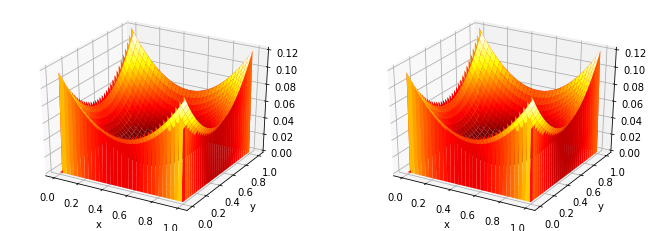

In [10]:
penalisation(f,0.2,100,0.00000001)